In [1]:
%load_ext autoreload
%autoreload 2

# Wake from Gaussian

In [2]:
from csr3d.csr1d import csr1d_steady_state_kick_calc

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import scipy.constants
from scipy.interpolate import RegularGridInterpolator
mec2 = scipy.constants.value("electron mass energy equivalent in MeV") * 1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value("classical electron radius")

# Parameters

In [5]:
#sigma_z = 40e-6
#sigma_x = 134e-6 
#rho = 1538.
#gamma = 58708.

sigma_x = 10e-6
sigma_y = 10e-6 
sigma_z = 10e-6 

rho = 1.
gamma = 500.


beta = np.sqrt(1 - 1 / gamma ** 2)
beta2 = 1-1/gamma**2

# Characteristic wake in eV/m from Chris's paper
#W0 = Nb* r_e * mec2 *(sigma_z/abs(rho))**(2/3) / sigma_z**2

# Density

In [6]:
xmax = sigma_x*5
xmin = -xmax
xptp = xmax-xmin

ymax = sigma_y*5
ymin = -ymax
yptp = ymax-ymin

zmax = sigma_z*5
zmin = -zmax
zptp = zmax-zmin

nx = 256
ny = 256
nz = 256


dx = xptp/(nx-1)
dy = yptp/(ny-1)
dz = zptp/(nz-1)

deltas = (dx, dy, dz)

xvec = np.linspace(xmin, xmax, nx)
yvec = np.linspace(ymin, ymax, ny)
zvec = np.linspace(zmin, zmax, nz)

X, Y, Z = np.meshgrid( xvec, yvec, zvec, indexing='ij')

In [7]:
from csr3d.dist import gauss, lambda_gauss3, lambda_gauss3_prime

In [8]:
density = lambda_gauss3(X, Y, Z, sigma_x=sigma_x, sigma_y=sigma_y, sigma_z=sigma_z)
norm = np.sum(density) * dx * dy *dz
density /= norm
density_prime = lambda_gauss3_prime(X, Y, Z, sigma_x=sigma_x, sigma_y=sigma_y, sigma_z=sigma_z) /norm

In [9]:
# Check that this is 1
np.sum(density)* dx * dy *dz

0.9999999999999996

# Green function

In [10]:
from csr3d.wake import green_mesh

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
%%time
Gs = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='s')

CPU times: user 25.4 s, sys: 2.53 s, total: 27.9 s
Wall time: 5.4 s


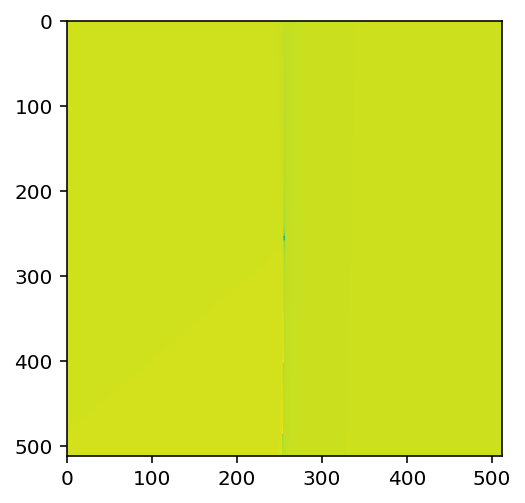

In [12]:
plt.imshow(Gs[:,ny-1,:])

# Convolution

In [13]:
from csr3d.convolution import fftconvolve3

In [14]:
%%time
Ws = fftconvolve3(density_prime, Gs)[0]
Ws.shape

CPU times: user 10.7 s, sys: 2.25 s, total: 13 s
Wall time: 13.2 s


(256, 256, 256)

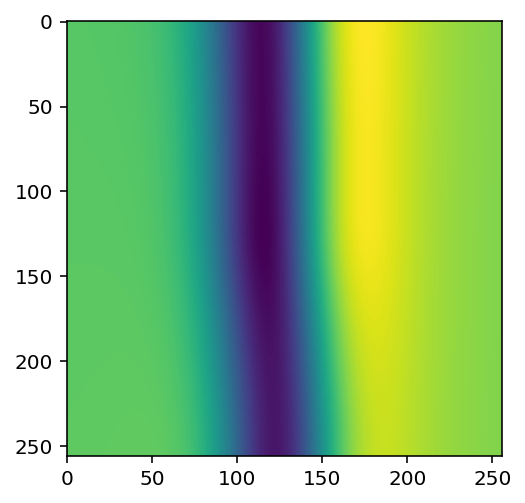

In [15]:
plt.imshow(Ws[:,ny//2,:])

# Wake plot

$\Psi_s$

Compare with Fig. 5 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402

In [16]:
# Conversion factor for 1/m^2
factor = (beta2 / (rho)) * (dx * dy * dz)
factor

6.030838817649323e-20

In [17]:
# Quickly get nearest indices for +/- sigma_x
ix_pos = np.abs((xvec/sigma_x) - (1)).argmin()
ix_neg = np.abs((xvec/sigma_x) - (-1)).argmin()
(xvec/sigma_x)[ix_pos], (xvec/sigma_x)[ix_neg]

(1.0000000000000004, -0.9999999999999998)

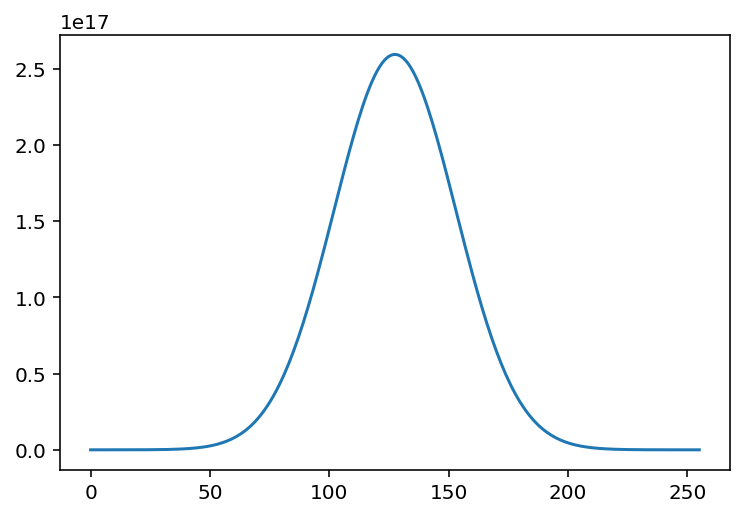

In [18]:
plt.plot(np.sum(np.sum(density, axis=0), axis=0))

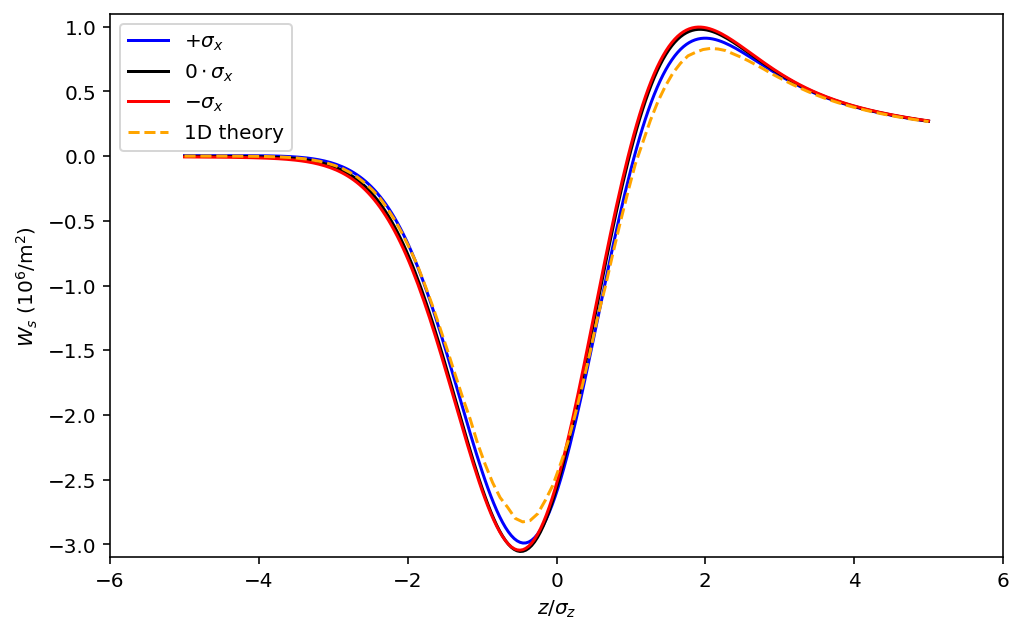

In [19]:
# 1D CSR steady state wake
zvec1 = np.linspace(zmin, zmax, 10*nz)
density1 = gauss(zvec1, sigma=sigma_z)
SS = csr1d_steady_state_kick_calc(zvec1, density1, normalized_units=True)

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
ax.set_ylim(-3.1,1.1)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_s$ ($10^6$/m$^2)$')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
  
ax.plot(zvec/sigma_z, Ws[ix_pos, ny//2, :]*factor/1e6, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Ws[nx//2, ny//2,  :]*factor/1e6, color='black', label=r'$0\cdot\sigma_x$')  
ax.plot(zvec/sigma_z, Ws[ix_neg, ny//2, :]*factor/1e6, label=r'$-\sigma_x$', color='red') 
ax.plot(SS['zvec']/sigma_z, SS['wake']/1e6, color='orange', linestyle='--', label='1D theory')
ax.legend()

# psi_xhat

$\hat{\Psi}_x = \Psi_x - \Psi_\phi$ from Eq. 24

Compare with Fig. 6 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402

In [20]:
%%time
Gxhat = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='xhat')
Gxhat.min()

CPU times: user 1min 24s, sys: 4.17 s, total: 1min 28s
Wall time: 15.3 s


-6.798244327415461

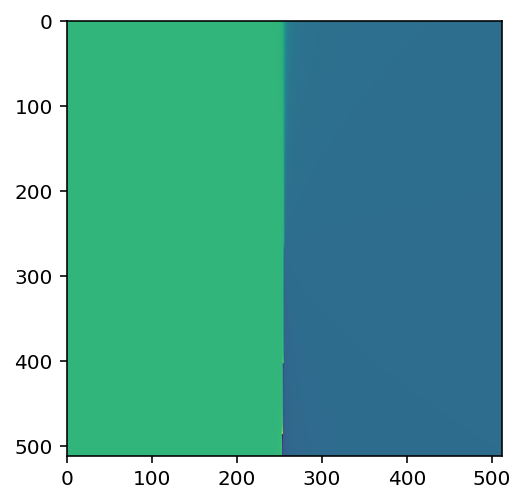

In [21]:
plt.imshow(Gxhat[:,ny-1,:])

In [22]:
%%time
Wxhat = fftconvolve3(density_prime, Gxhat)[0]
Wxhat.shape

CPU times: user 9.9 s, sys: 1.65 s, total: 11.6 s
Wall time: 11.9 s


(256, 256, 256)

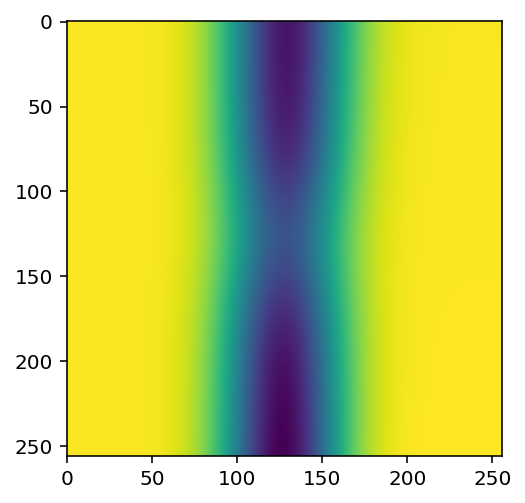

In [23]:
plt.imshow(Wxhat[:,ny//2,:])

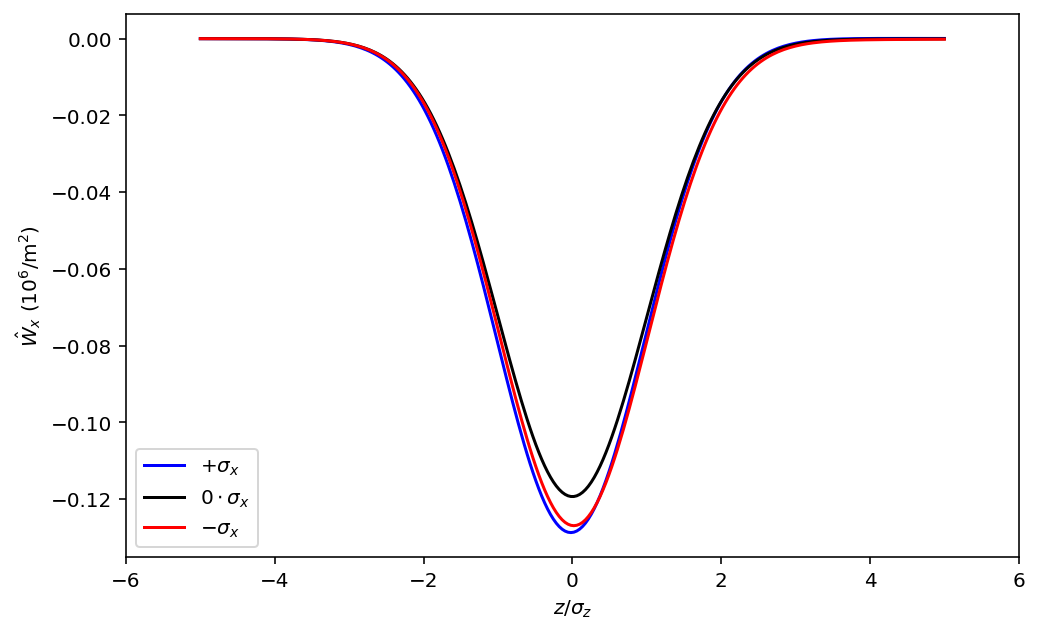

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$\hat{W}_x$ ($10^6$/m$^2$)')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wxhat[ix_pos, ny//2, :]*factor/1e6, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Wxhat[nx//2, ny//2, : ]*factor/1e6, color='black',label=r'$0\cdot\sigma_x$') 
ax.plot(zvec/sigma_z, Wxhat[ix_neg, ny//2, :]*factor/1e6, label=r'$-\sigma_x$', color='red')  
  

ax.legend()

# psi_x

$\Psi_x$ from Eq. 24

In [25]:
%%time
Gx = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='x')
Gx.min()

CPU times: user 1min 26s, sys: 5.45 s, total: 1min 31s
Wall time: 19.9 s


-13.74377622313018

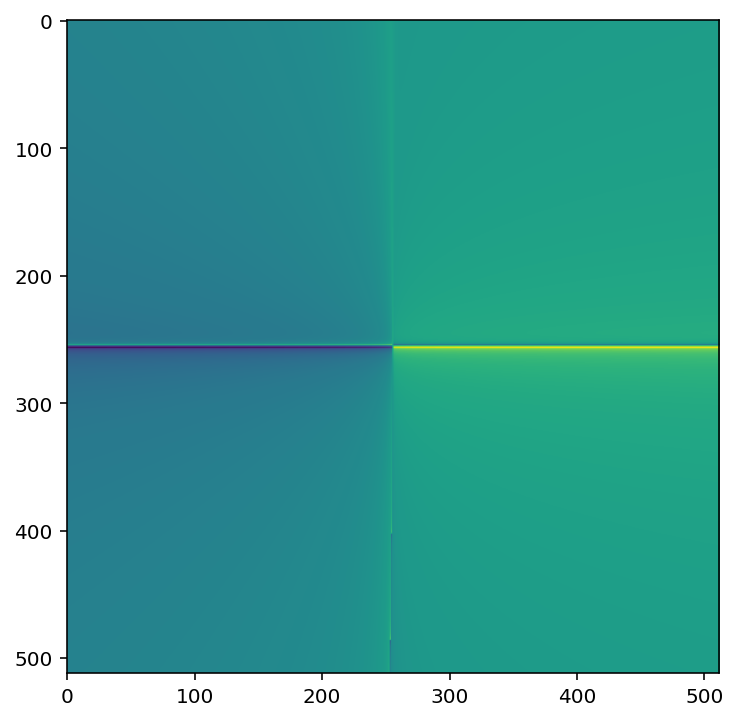

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Gx[:,ny-1,:])

In [27]:
%%time
Wx = fftconvolve3(density_prime, Gx)[0]
Wx.shape

CPU times: user 11.5 s, sys: 3.6 s, total: 15.1 s
Wall time: 15.7 s


(256, 256, 256)

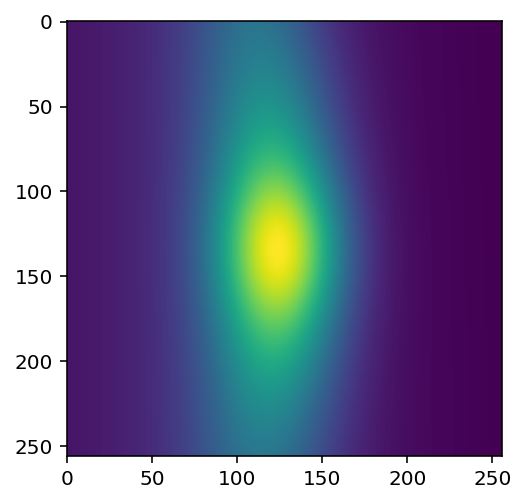

In [28]:
plt.imshow(Wx[:,ny//2,:])

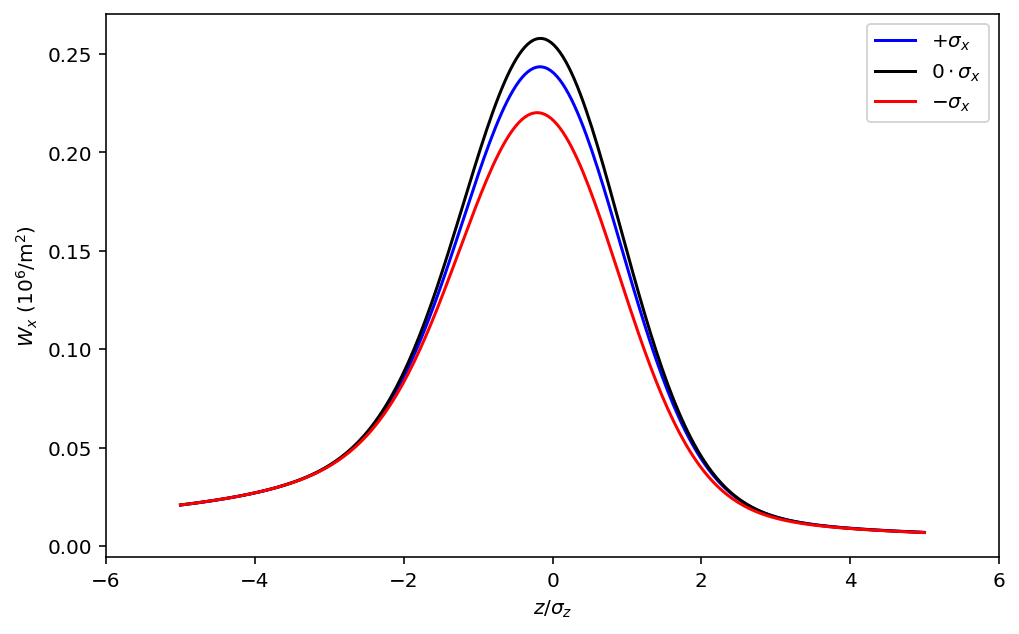

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_x$ ($10^6$/m$^2$)')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wx[ix_pos, ny//2, :]*factor/1e6, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Wx[nx//2, ny//2, :] *factor/1e6,  label=r'$0\cdot\sigma_x$', color='black')   
ax.plot(zvec/sigma_z, Wx[ix_neg, ny//2, :]*factor/1e6, label=r'$-\sigma_x$', color='red')  
ax.legend()

# Fx IGF

In [30]:
%%time
Gx_IGF = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='Fx_IGF')
Gx_IGF.min()

/Users/chrisonian/Code/GitHub/CSR3D/csr3d/wake.py:125: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func_z, -dz/2, dz/2, points = [0])[0]
/Users/chrisonian/Code/GitHub/CSR3D/csr3d/wake.py:125: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func_z, -dz/2, dz/2, points = [0])[0]
/Users/chrisonian/Code/GitHub/CSR3D/csr3d/wake.py:128: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the 

CPU times: user 50min 56s, sys: 49.1 s, total: 51min 45s
Wall time: 7min 4s


-1256553244.5716143

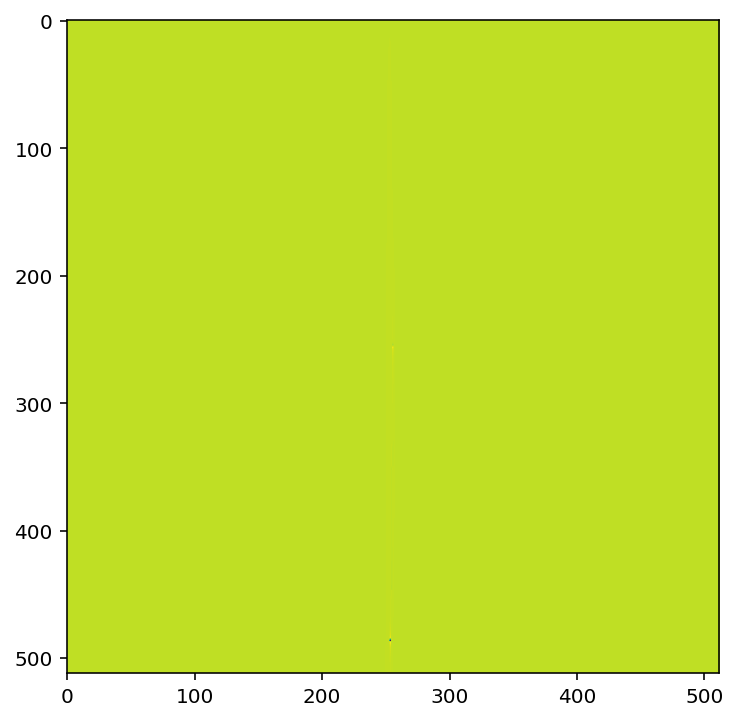

In [31]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Gx_IGF[:,ny-1,:])

In [32]:
%%time
Wx_IGF = fftconvolve3(density, Gx_IGF)[0]
Wx_IGF.shape

CPU times: user 10 s, sys: 1.68 s, total: 11.7 s
Wall time: 11.9 s


(256, 256, 256)

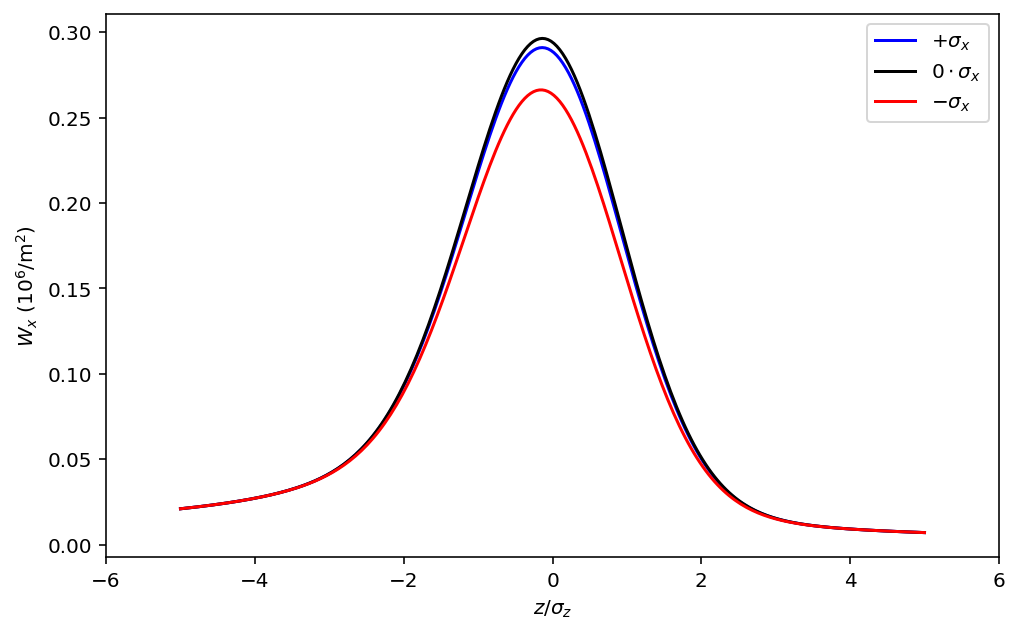

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_x$ ($10^6$/m$^2$)')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wx_IGF[ix_pos, ny//2, :]*factor/1e6, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Wx_IGF[nx//2, ny//2, :] *factor/1e6,  label=r'$0\cdot\sigma_x$', color='black')   
ax.plot(zvec/sigma_z, Wx_IGF[ix_neg, ny//2, :]*factor/1e6, label=r'$-\sigma_x$', color='red')  
ax.legend()

# psi_phi

In [34]:
%%time
Gphi = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='phi')
Gphi.min()

CPU times: user 52.9 s, sys: 4.68 s, total: 57.5 s
Wall time: 11 s


-6.234436663575099

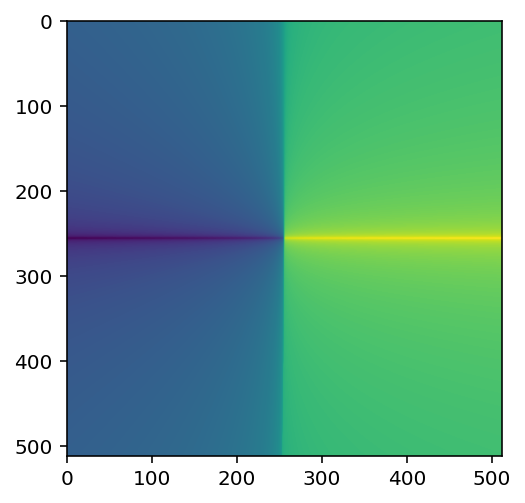

In [35]:
plt.imshow(Gphi[:,ny-1,:])

In [36]:
%%time
Wphi = fftconvolve3(density_prime, Gphi)[0]
Wphi.shape

CPU times: user 11.4 s, sys: 3.66 s, total: 15 s
Wall time: 16.5 s


(256, 256, 256)

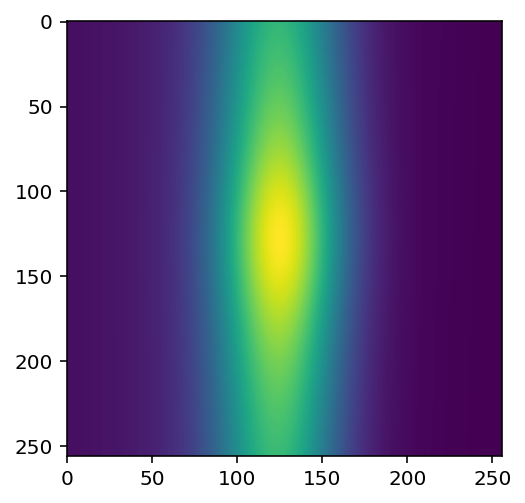

In [37]:
plt.imshow(Wphi[:,ny//2,:])

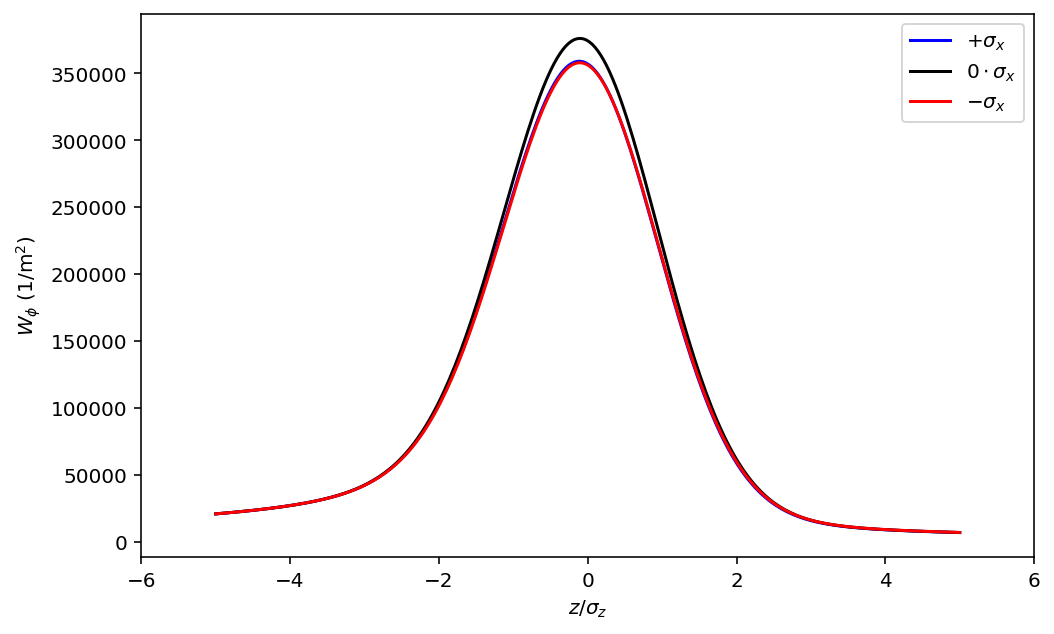

In [38]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_\phi$ (1/m$^{2}$)')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wphi[ix_pos, ny//2, :]*factor, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Wphi[nx//2, ny//2, :]*factor, label=r'$0\cdot\sigma_x$', color='black')      
ax.plot(zvec/sigma_z, Wphi[ix_neg, ny//2, :]*factor, label=r'$-\sigma_x$', color='red')  
ax.legend()

# psi_y

Compare with Fig. 8 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402



In [39]:
%%time
Gy = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='y')

CPU times: user 1min 39s, sys: 4.31 s, total: 1min 43s
Wall time: 16.7 s


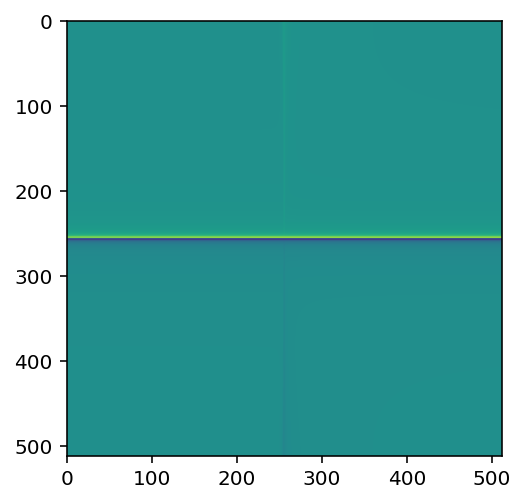

In [40]:
plt.imshow(Gy[nx-1,:,:])

In [41]:
%%time
Wy = fftconvolve3(density_prime, Gy)[0]
Wy.shape

CPU times: user 11.5 s, sys: 4.53 s, total: 16 s
Wall time: 16.8 s


(256, 256, 256)

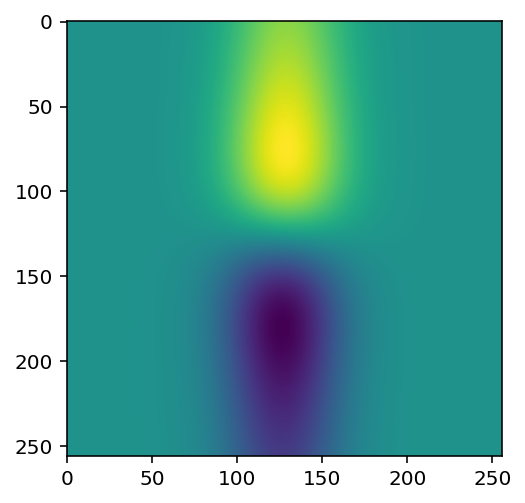

In [42]:
plt.imshow(Wy[:,ny//2,:])

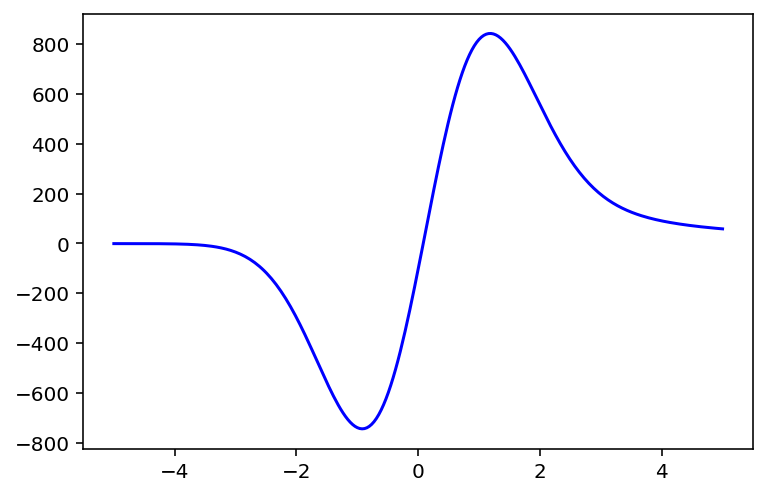

In [43]:

iy_pos = np.abs((yvec/sigma_y) - (1)).argmin()

plt.plot(zvec/sigma_z, Wy[nx//2-1, iy_pos, :]*factor, color='blue') 

In [44]:
(yvec/sigma_y)[iy_pos]

1.0000000000000004

In [45]:
(xvec/sigma_x)[nx//2-1]

-0.019607843137254447

Text(0, 0.5, '$W_y (m^{-2})$')

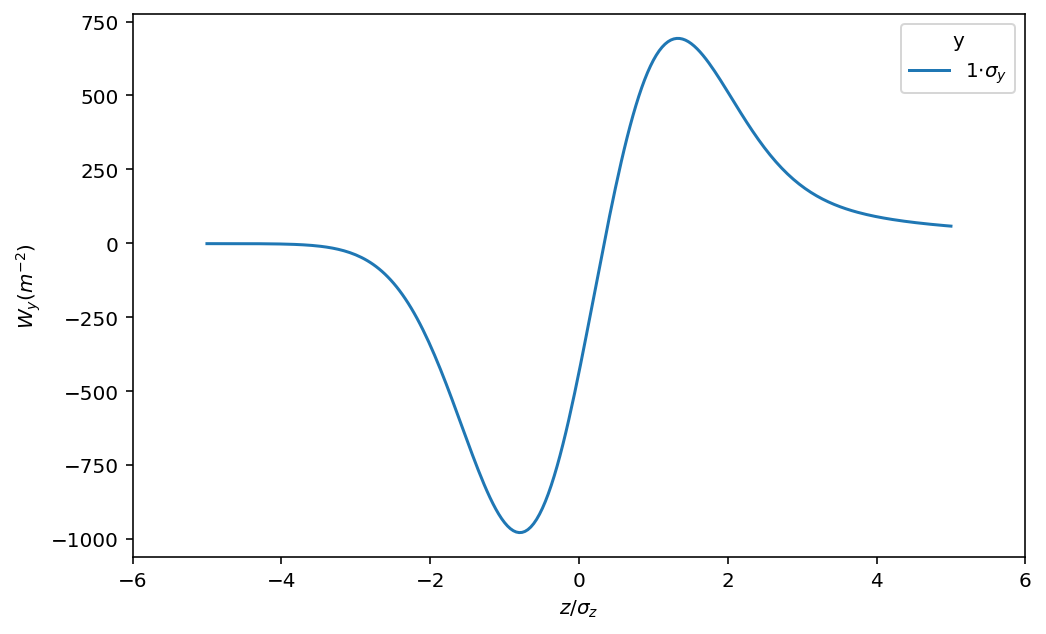

In [46]:
# Make interpolator
Wy_interp = RegularGridInterpolator([xvec, yvec, zvec], Wy)


fig, ax = plt.subplots(figsize=(8,5))
for yi in [1]: #np.arange(-1,1.5,0.5):
    pts = np.array([[0, yi*sigma_y, z] for z in zvec])
    vals = Wy_interp(pts)
    ax.plot(zvec/sigma_z, vals*factor, label=f'{yi}'+r'$\cdot\sigma_y$')
ax.legend(title='y')

ax.set_xlim(-6,6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_y (m^{-2})$')

# Fy IGF

In [47]:
%%time
Gy_IGF = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='Fy_IGF')
Gy_IGF.min()

/Users/chrisonian/Code/GitHub/CSR3D/csr3d/wake.py:125: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func_z, -dz/2, dz/2, points = [0])[0]
/Users/chrisonian/Code/GitHub/CSR3D/csr3d/wake.py:125: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func_z, -dz/2, dz/2, points = [0])[0]
/Users/chrisonian/Code/GitHub/CSR3D/csr3d/wake.py:128: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the 

CPU times: user 1h 7min 47s, sys: 1min 4s, total: 1h 8min 52s
Wall time: 9min 20s


-278581752.1462955

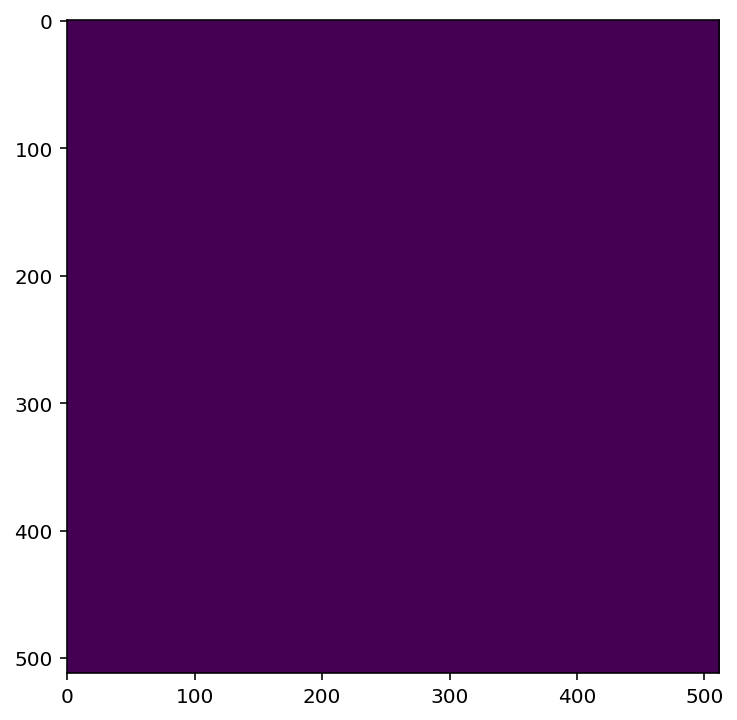

In [48]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Gy_IGF[:,ny-1,:])

In [49]:
%%time
Wy_IGF = fftconvolve3(density, Gy_IGF)[0]
Wy_IGF.shape

CPU times: user 10.7 s, sys: 1.84 s, total: 12.6 s
Wall time: 12.9 s


(256, 256, 256)

Text(0, 0.5, '$W_y$ (m$^{-2}$) from Fy IGF')

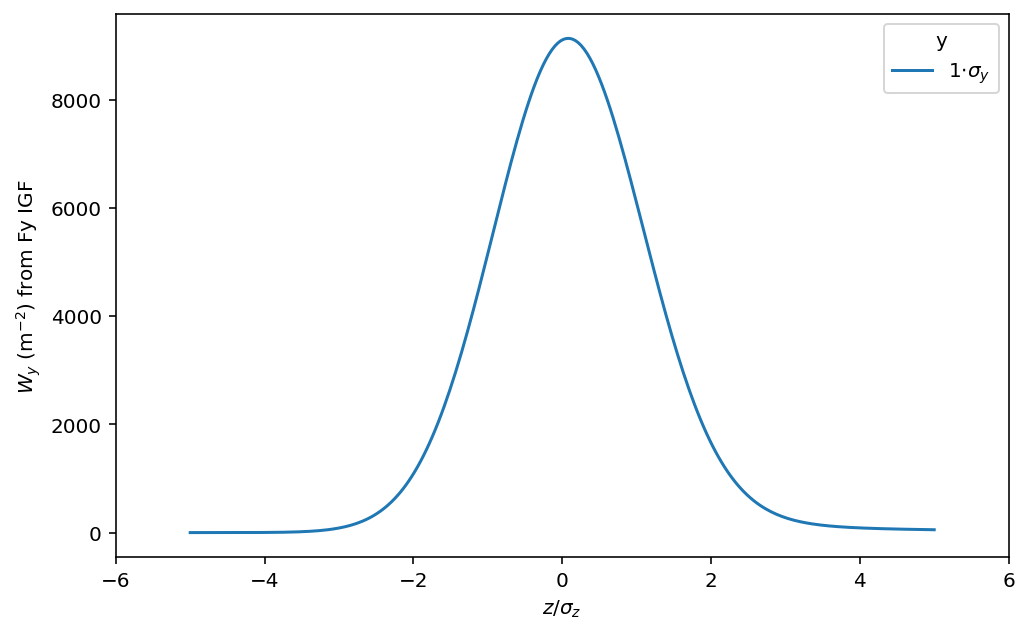

In [65]:
# Make interpolator
Wy_IGF_interp = RegularGridInterpolator([xvec, yvec, zvec], Wy_IGF)


fig, ax = plt.subplots(figsize=(8,5))
for yi in [1]: #np.arange(-1,1.5,0.5):
    pts = np.array([[0, yi*sigma_y, z] for z in zvec])
    vals = Wy_IGF_interp(pts)
    ax.plot(zvec/sigma_z, vals*factor, label=f'{yi}'+r'$\cdot\sigma_y$')
ax.legend(title='y')

ax.set_xlim(-6,6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_y$ (m$^{-2}$) from Fy IGF')

# 3D plot

In [58]:
cdata = density.sum(axis=1)
from mpl_toolkits.mplot3d import Axes3D
cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(cdata/cdata.max())

X, Z= np.meshgrid(xvec, zvec, indexing="ij")

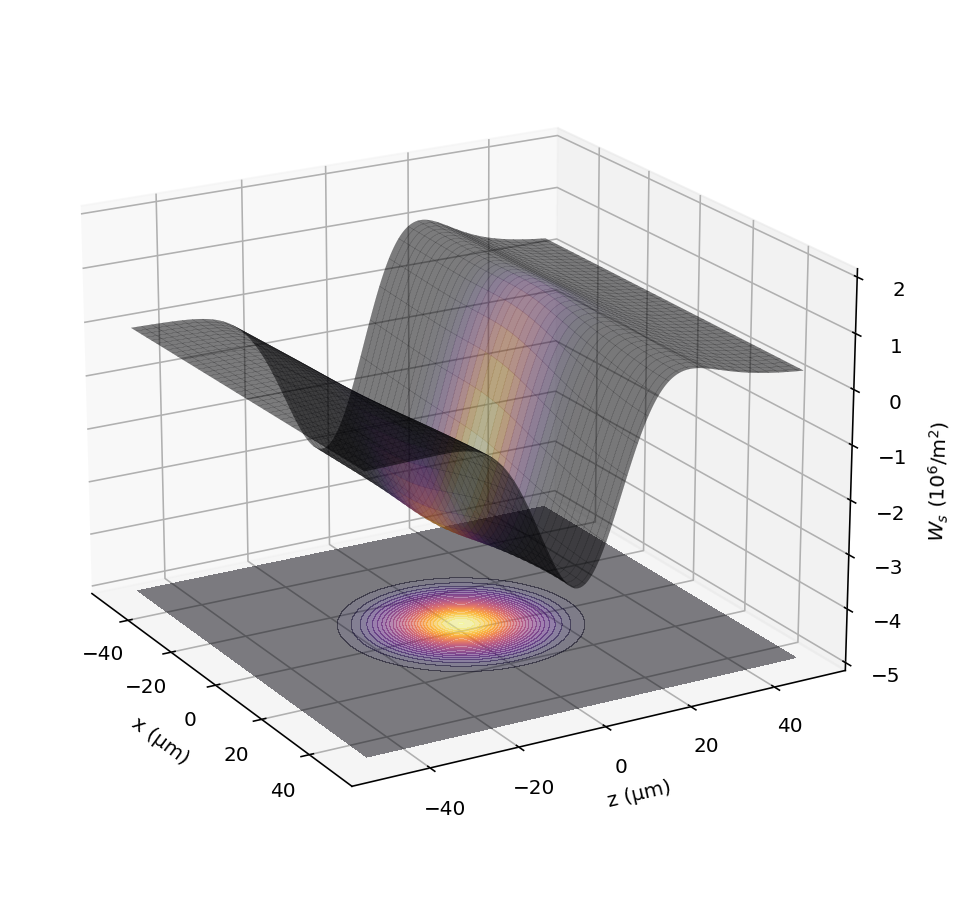

In [59]:
LABEL=r'$W_s~(10^6/$m$^2$)'
PFILE = f'../img/Ws_3d.png'
W = Ws[:,ny//2,:]*factor

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
ax.contourf(X/1e-6, Z/1e-6, cdata, 30, zdir='z', offset=-5, 
           extent=[zmin, zmax, xmin, xmax], cmap=cmap, alpha=0.5)
#ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(-5, 2)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+60)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

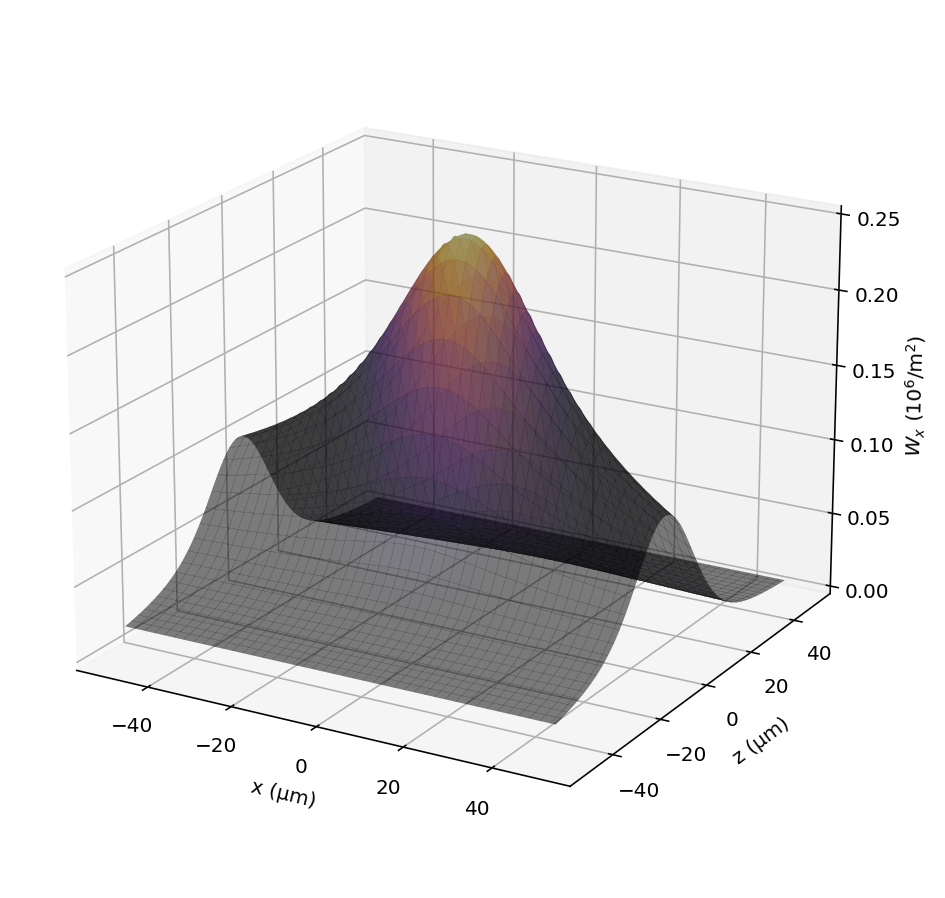

In [60]:
LABEL=r'$W_x~(10^6/$m$^2$)'
PFILE = f'../img/Wx_3d.png'
W = Wx[:,ny//2,:]*factor

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
#ax.contourf(X/1e-6, Z/1e-6, cdata, 10, zdir='z', offset=0, 
 #          extent=[zmin, zmax, xmin, xmax], cmap=cmap)
#ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(0, 2.5e5/1e6)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+30)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

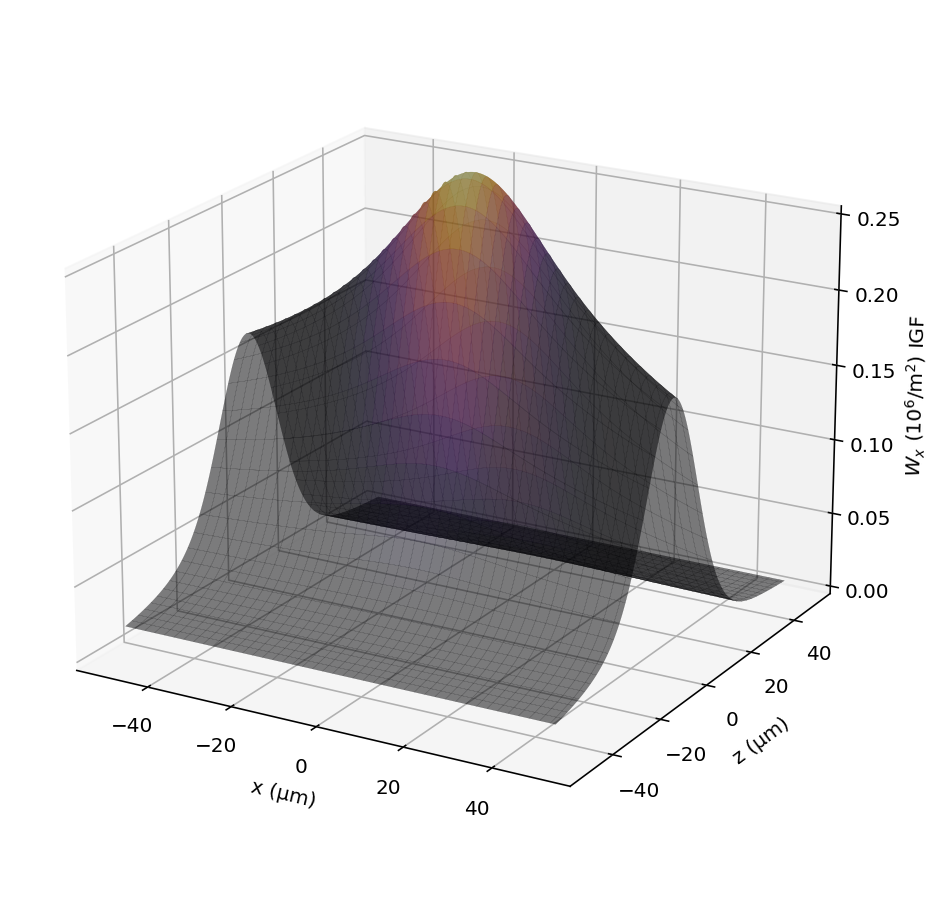

In [61]:
LABEL=r'$W_x~(10^6/$m$^2$) IGF'
PFILE = f'../img/Wx_IGF_3d.png'
W = Wx_IGF[:,ny//2,:]*factor

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
#ax.contourf(X/1e-6, Z/1e-6, cdata, 10, zdir='z', offset=0, 
 #          extent=[zmin, zmax, xmin, xmax], cmap=cmap)
#ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(0, 2.5e5/1e6)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+30)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

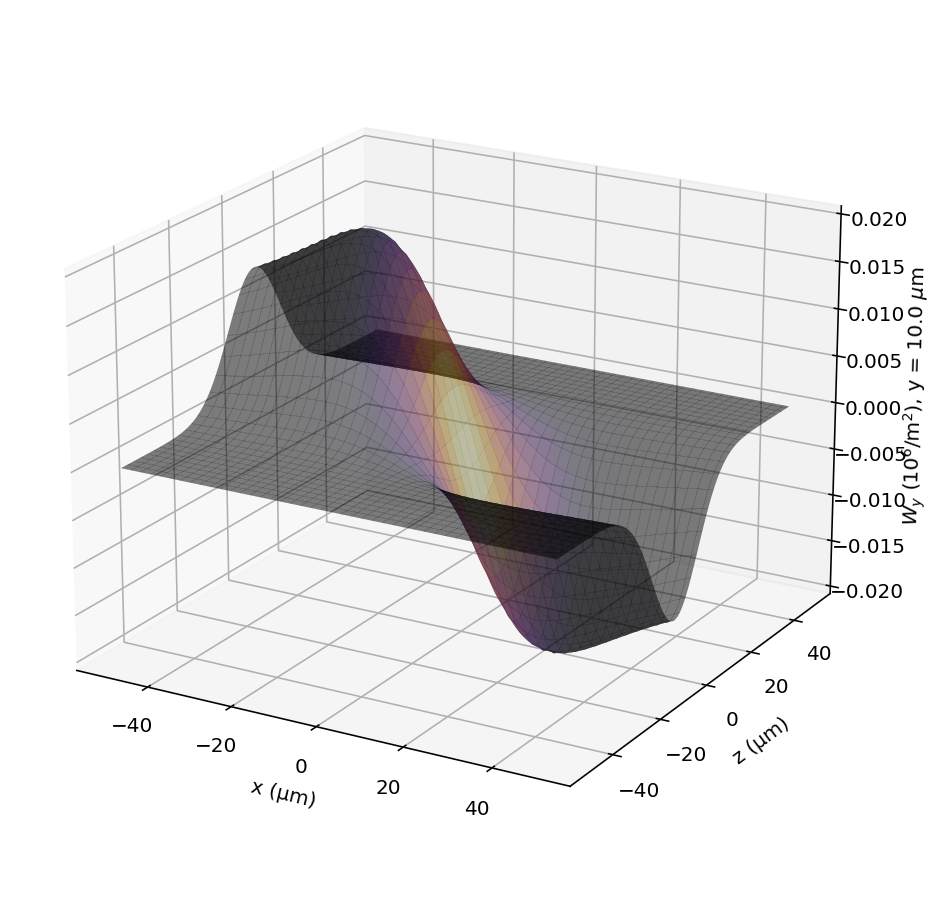

In [62]:
LABEL=rf'$W_y~(10^6/$m$^2$), y = {Y[0,iy_pos,0]/1e-6:0.1f} $\mu$m'
PFILE = f'../img/Wy_3d.png'
W = Wy[:,iy_pos,:]*factor

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
#ax.contourf(X/1e-6, Z/1e-6, cdata, 10, zdir='z', offset=0, 
 #          extent=[zmin, zmax, xmin, xmax], cmap=cmap)
#ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(-.02, .02)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+30)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

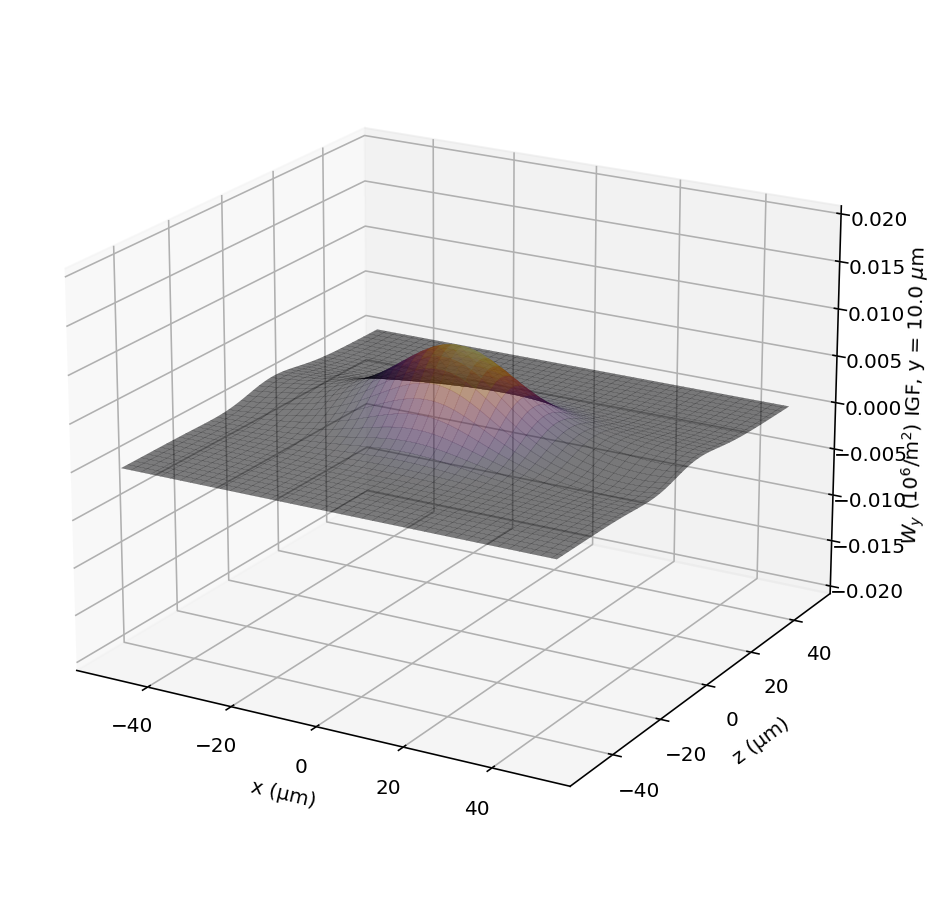

In [63]:
LABEL=rf'$W_y~(10^6/$m$^2$) IGF, y = {Y[0,iy_pos,0]/1e-6:0.1f} $\mu$m'
PFILE = f'../img/Wy_IGF_3d.png'
W = Wy_IGF[:,iy_pos,:]*factor

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
#ax.contourf(X/1e-6, Z/1e-6, cdata, 10, zdir='z', offset=0, 
 #          extent=[zmin, zmax, xmin, xmax], cmap=cmap)
#ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(-.02, .02)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+30)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")